In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading ADNI test data
python inference.py --dataset_location data/adni_test_scaled_corrected.csv --dataset_id adni

python inference.py --dataset_location data/adni_test_scaled_corrected.csv --dataset_id adni --do_single_pass

In [2]:
nacc_diag = pd.read_csv('../data/nacc_diagnosis.csv', index_col=0)
nacc_diag.shape

(5209, 1)

In [6]:
adni_diag = pd.read_csv('../data/adni_test_scaled_corrected.csv', index_col=0)['diagnosis']
adni_diag

subj
sub-002-S-1018    1
sub-002-S-4213    0
sub-003-S-0981    0
sub-003-S-1059    1
sub-003-S-4373    1
                 ..
sub-130-S-4641    1
sub-130-S-4971    1
sub-130-S-4990    1
sub-131-S-0441    0
sub-133-S-1055    1
Name: diagnosis, Length: 74, dtype: int64

In [5]:
res_df = pd.read_csv('latest_output_adni_50.csv', index_col=0)
res_df

,mean,std
adni_id,,
sub-002-S-1018,0.450929,0.205836
sub-002-S-4213,0.023119,0.044911
sub-003-S-0981,0.021117,0.023417
sub-003-S-1059,0.870995,0.138541
sub-003-S-4373,0.971531,0.034938
...,...,...
sub-130-S-4641,0.187707,0.135776
sub-130-S-4971,0.783757,0.175471
sub-130-S-4990,0.961426,0.036407


In [7]:
joined_df = res_df.join(adni_diag, how='inner')
joined_df

,mean,std,diagnosis
adni_id,,,
sub-002-S-1018,0.450929,0.205836,1
sub-002-S-4213,0.023119,0.044911,0
sub-003-S-0981,0.021117,0.023417,0
sub-003-S-1059,0.870995,0.138541,1
sub-003-S-4373,0.971531,0.034938,1
...,...,...,...
sub-130-S-4641,0.187707,0.135776,1
sub-130-S-4971,0.783757,0.175471,1
sub-130-S-4990,0.961426,0.036407,1


## How mean/std look like in ADNI test set

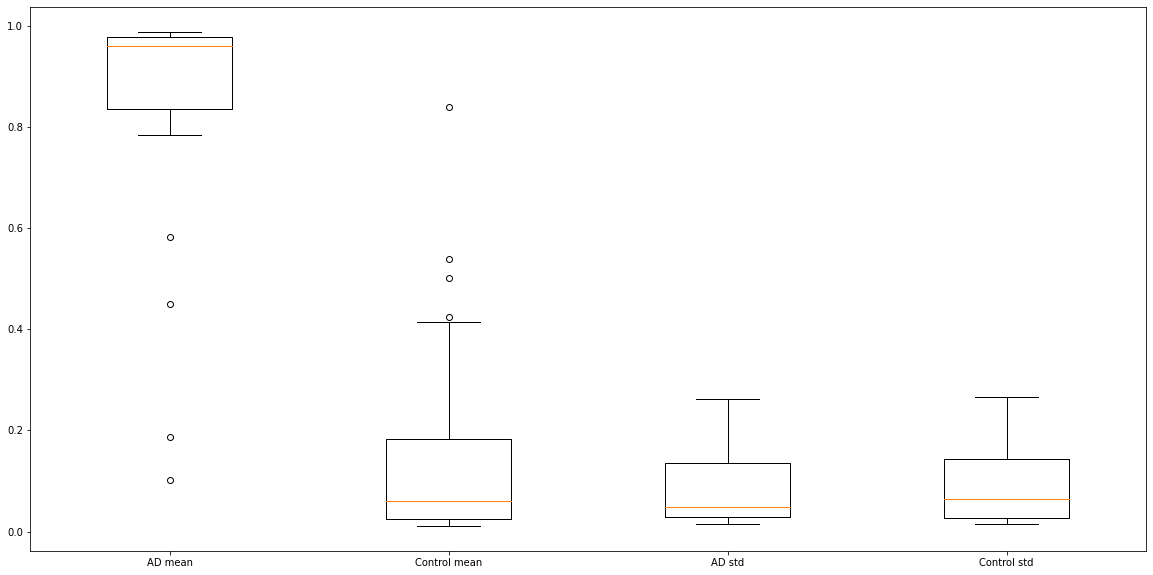

In [8]:
plt.subplots(figsize=(20, 10))
all_data = [joined_df[joined_df.diagnosis == 1]['mean'].values, 
            joined_df[joined_df.diagnosis == 0]['mean'].values,
            ##
            joined_df[joined_df.diagnosis == 1]['std'].values,
            joined_df[joined_df.diagnosis == 0]['std'].values,]


_ = plt.boxplot(all_data, labels=['AD mean', 'Control mean',
                                  'AD std', 'Control std'])
plt.show()
plt.close()

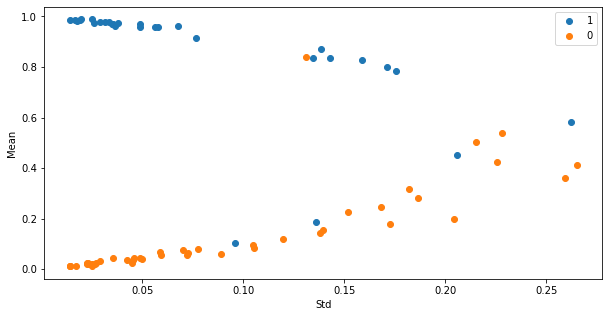

In [9]:
plt.subplots(figsize=(10, 5))

for diagnosis in [1, 0]:
    tmp_df = joined_df[joined_df.diagnosis == diagnosis]

    plt.scatter(tmp_df['std'], tmp_df['mean'], label=diagnosis)

plt.legend()
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()
plt.close()

## MC-Drop vs single-pass: AUC Roc Curve

In [10]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [12]:
single_pass = pd.read_csv('latest_output_adni_1.csv', index_col=0)
single_pass = single_pass.join(adni_diag, how='inner')
#single_pass = single_pass[(single_pass.diagnosis == 'AD') | (single_pass.diagnosis == 'Control')]
single_pass

,mean,std,diagnosis
adni_id,,,
sub-002-S-1018,0.447093,NaN,1
sub-002-S-4213,0.005362,NaN,0
sub-003-S-0981,0.009145,NaN,0
sub-003-S-1059,0.957235,NaN,1
sub-003-S-4373,0.991371,NaN,1
...,...,...,...
sub-130-S-4641,0.121516,NaN,1
sub-130-S-4971,0.859160,NaN,1
sub-130-S-4990,0.988055,NaN,1


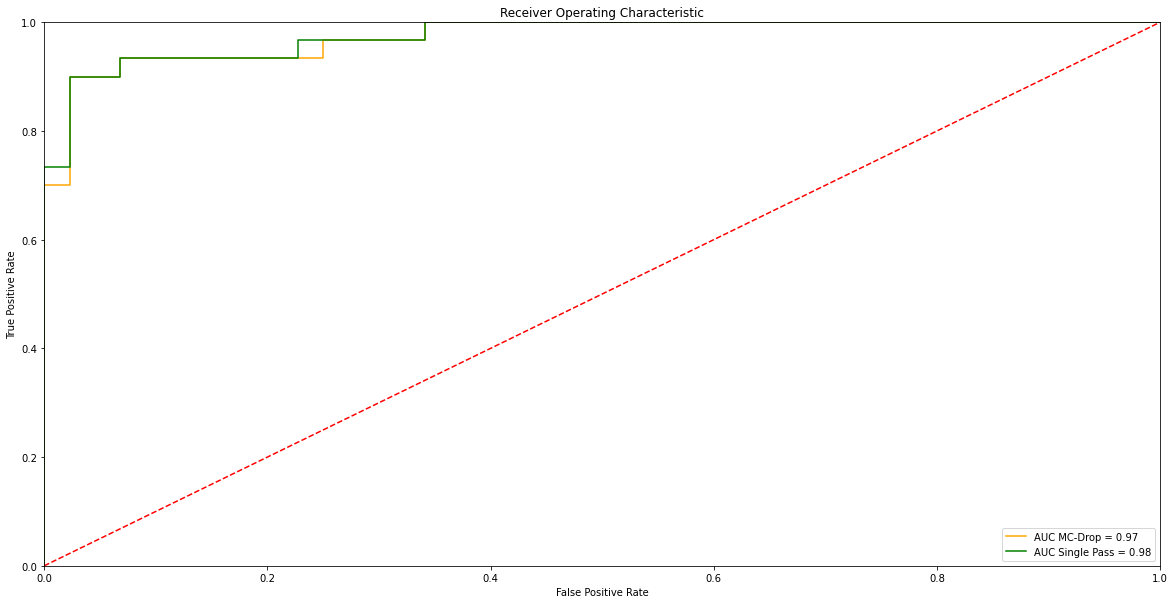

In [13]:

def plot_roc_stuff(tmp_df, label, color):
    preds = tmp_df['mean']
    fpr, tpr, threshold = metrics.roc_curve(tmp_df['diagnosis'], preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)

plt.subplots(figsize=(20, 10))
plt.title('Receiver Operating Characteristic')
plot_roc_stuff(joined_df, 'MC-Drop', 'orange')
plot_roc_stuff(single_pass, 'Single Pass', 'green')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.close()

## MC-Drop (uncertainty) vs MC-Drop (delta) vs single-pass (delta)

In [71]:
def populate_arrs_for_df(df, accs_arr, sens_arr, spes_arr, people_arr):
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    tn, fp, fn, tp = metrics.confusion_matrix(tmp_df['diagnosis'].values, probs).ravel()
    specificity = tn / (tn+fp)
    sensitivty = tp / (tp+fn)
    
    accs_arr.append(metrics.accuracy_score(tmp_df['diagnosis'].values, probs))
    sens_arr.append(sensitivty)
    spes_arr.append(specificity)
    people_arr.append(tmp_df.shape[0])
    

### MC-Drop with uncertainty thresholding

In [89]:
accs = []
sens = []
spes = []
people = []
for std_val in np.arange(0.015, 0.36, 0.001):
    
    tmp_df = joined_df.loc[joined_df['std'] < std_val, :]
    populate_arrs_for_df(tmp_df, accs, sens, spes, people)

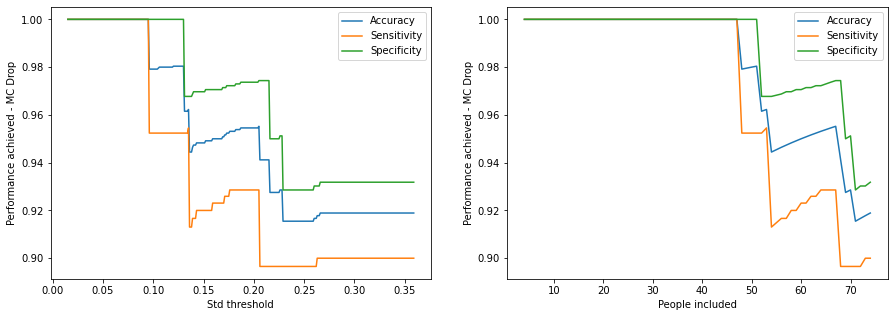

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.arange(0.015, 0.36, 0.001), accs, label='Accuracy')
axs[0].plot(np.arange(0.015, 0.36, 0.001), sens, label='Sensitivity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), spes, label='Specificity')
axs[0].set_xlabel('Std threshold')
axs[0].set_ylabel('Performance achieved - MC Drop')
axs[0].legend()

axs[1].plot(people, accs, label='Accuracy')
axs[1].plot(people, sens, label='Sensitivity')
axs[1].plot(people, spes, label='Specificity')
axs[1].set_xlabel('People included')
axs[1].set_ylabel('Performance achieved - MC Drop')
axs[1].legend()

plt.show()

### MC-Drop vs Single-pass with probability-delta thresholding

In [73]:
accs_delta_mc, accs_delta_1 = [], []
sens_delta_mc, sens_delta_1 = [], []
spes_delta_mc, spes_delta_1 = [], []
people_delta_mc, people_delta_1 = [], []

for delta_val in np.arange(0.012, 0.51, 0.001):

    tmp_df = joined_df.loc[(joined_df['mean'] < delta_val) | (joined_df['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_mc, sens_delta_mc, spes_delta_mc, people_delta_mc)
    
    tmp_df = single_pass.loc[(single_pass['mean'] < delta_val) | (single_pass['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_1, sens_delta_1, spes_delta_1, people_delta_1)

In [84]:
def plot_across_metrics(x_vals_mc, x_vals_1, x_label):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].plot(x_vals_mc, accs_delta_mc, label='Accuracy - MC Drop')
    axs[0].plot(x_vals_1, accs_delta_1, label='Accuracy - Single')

    axs[1].plot(x_vals_mc, sens_delta_mc, label='Sensitivity - MC Drop')
    axs[1].plot(x_vals_1, sens_delta_1, label='Sensitivity - Single')

    axs[2].plot(x_vals_mc, spes_delta_mc, label='Specificity - MC Drop')
    axs[2].plot(x_vals_1, spes_delta_1, label='Specificity - Single')

    for ax in axs:
        ax.set_xlabel(x_label)
        ax.set_ylabel('Performance achieved')
        ax.legend()
    
    plt.show()

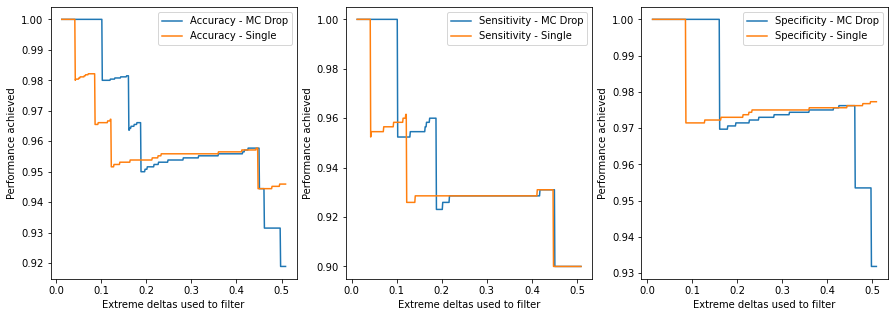

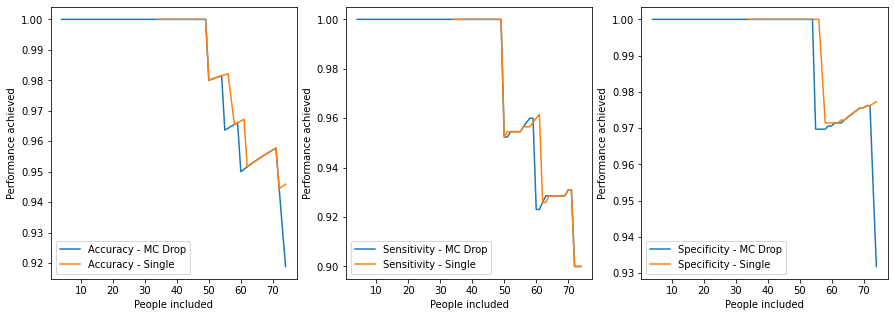

In [85]:
plot_across_metrics(np.arange(0.012, 0.51, 0.001), np.arange(0.012, 0.51, 0.001), 'Extreme deltas used to filter')
plot_across_metrics(people_delta_mc, people_delta_1, 'People included')


## Comparing the three approaches across people included

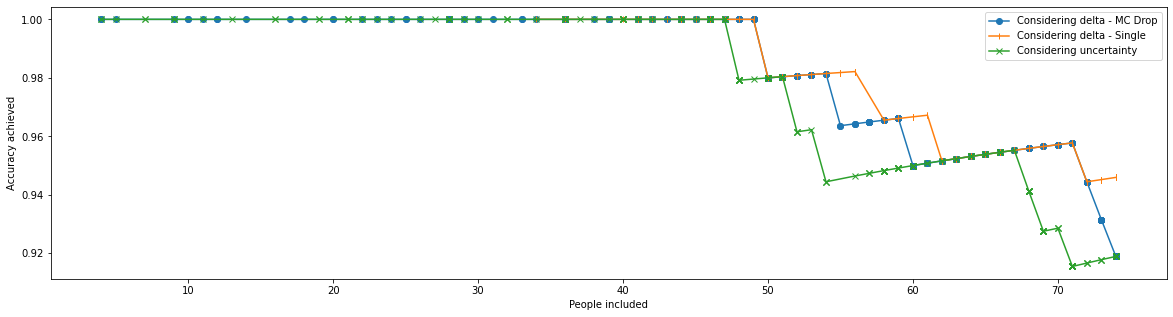

In [88]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, accs_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, accs_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, accs, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Accuracy achieved')
plt.legend()
plt.show()

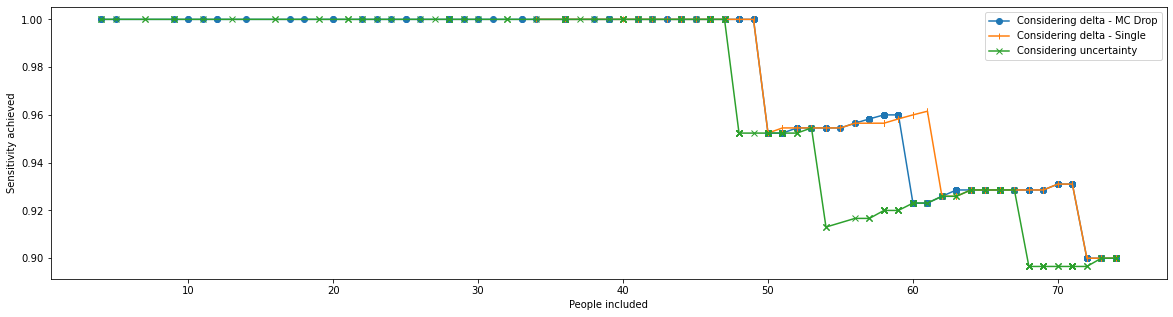

In [91]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, sens_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, sens_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, sens, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Sensitivity achieved')
plt.legend()
plt.show()

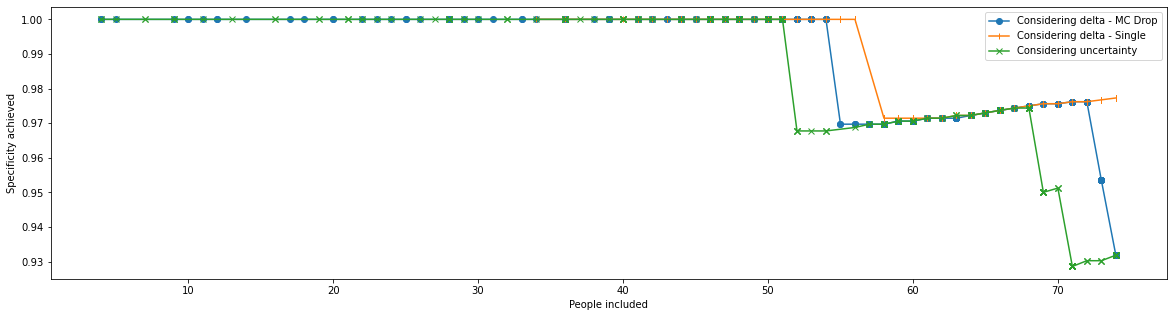

In [92]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, spes_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, spes_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, spes, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Specificity achieved')
plt.legend()
plt.show()